# 3. Potential Outcomes and RCTs (R Implementation)

This notebook implements analysis of potential outcomes and randomized controlled trials using R.

## Assignment Requirements:
1. **Data Simulation (3 points)**: Simulate dataset with covariates, treatment, and outcome
2. **Estimating Average Treatment Effect (3 points)**: Simple and controlled regression estimates
3. **LASSO and Variable Selection (3 points)**: Use LASSO for covariate selection and ATE estimation

In [71]:
# Import required libraries
library(tidyverse)  # Includes dplyr, ggplot2, tidyr, etc.
library(glmnet)     # For LASSO regression
library(broom)      # For tidy model outputs
library(knitr)      # For nice tables
library(scales)     # For plot scales
library(gridExtra)  # For arranging plots
library(cowplot)    # For plot themes

# Set random seed for reproducibility
set.seed(123)

# Create output directory if it doesn't exist
output_dir <- normalizePath("../output")
if (!dir.exists(output_dir)) dir.create(output_dir, recursive = TRUE)

cat("📦 Libraries loaded successfully\n")
cat("📁 Output directory ready:", output_dir, "\n")

<U+0001F4E6> Libraries loaded successfully
<U+0001F4C1> Output directory ready: /Users/gabrielsaco/Documents/GitHub/Lasso_Potential_Outcomes_RCTs/R/output 
<U+0001F4C1> Output directory ready: /Users/gabrielsaco/Documents/GitHub/Lasso_Potential_Outcomes_RCTs/R/output 


In [72]:
# Install required packages if not already installed
required_packages <- c("tidyverse", "glmnet", "broom", "knitr", "scales", "gridExtra", "cowplot")
missing_packages <- required_packages[!required_packages %in% installed.packages()[, "Package"]]

if (length(missing_packages) > 0) {
    cat("Installing missing packages:", paste(missing_packages, collapse = ", "), "\n")
    install.packages(missing_packages, repos = "https://cran.rstudio.com/")
} else {
    cat("All required packages are already installed\n")
}

All required packages are already installed


## 3.1 Data Simulation (3 points)

### Assignment Requirements (2 points):

Simulate a dataset with n = 1000 individuals generating:

1. **Covariates X₁, X₂, X₃, X₄** (continuous or binary)
   - X₁, X₂: Continuous covariates  
   - X₃, X₄: Binary covariates

2. **Treatment assignment D ~ Bernoulli(0.5)**
   - Random treatment assignment with 50% probability

3. **Outcome variable following the exact specification:**
   $$Y = 2D + 0.5 X_1 - 0.3 X_2 + 0.2 X_3 + \epsilon, \quad \epsilon \sim N(0,1)$$
   
   Note: X₄ intentionally excluded (coefficient = 0) to test variable selection

4. **Save in a data.frame** structure (data.frame in R)

In [73]:
# Set parameters
n <- 1000

# Generate covariates
X1 <- rnorm(n, 2, 1)           # Continuous covariate
X2 <- rnorm(n, 0, 1.5)        # Continuous covariate
X3 <- rbinom(n, 1, 0.3)      # Binary covariate
X4 <- rbinom(n, 1, 0.6)      # Binary covariate

# Generate treatment assignment
D <- rbinom(n, 1, 0.5)       # Treatment ~ Bernoulli(0.5)

# Generate error term
epsilon <- rnorm(n, 0, 1)

# Generate outcome variable: Y = 2D + 0.5X1 - 0.3X2 + 0.2X3 + ε
Y <- 2*D + 0.5*X1 - 0.3*X2 + 0.2*X3 + epsilon

# Create DataFrame
data <- data.frame(
    Y = Y,
    D = D,
    X1 = X1,
    X2 = X2,
    X3 = X3,
    X4 = X4
)

cat("📊 Dataset simulated successfully\n")
cat("Sample size:", n, "\n")
cat("Treatment group size:", sum(data$D), "\n")
cat("Control group size:", sum(1 - data$D), "\n\n")

# Display first few rows
cat("First 5 rows of the dataset:\n")
head(data)

<U+0001F4CA> Dataset simulated successfully
Sample size: 1000 
Treatment group size: 487 
Control group size: 513 

First 5 rows of the dataset:
Sample size: 1000 
Treatment group size: 487 
Control group size: 513 

First 5 rows of the dataset:


,Y,D,X1,X2,X3,X4
,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>
1,4.642276,1,2.1292877,-3.8240142,0,0
2,1.460488,0,3.7150650,1.5608602,1,1
3,2.247346,0,2.4609162,0.3745886,0,1
4,1.233648,1,0.7349388,3.6243111,1,0
5,1.182687,1,1.3131471,1.0277974,0,1
6,4.498183,1,1.5543380,-0.6704390,0,0


### Balance Check (1 point)

We perform a balance check by comparing the means of X₁, X₂, X₃, X₄ across treatment and control groups.

In [74]:
# Balance check: compare means across treatment groups using t-tests
control_group <- data[data$D == 0, ]
treatment_group <- data[data$D == 1, ]

cat("🔍 Balance Check: Comparing Treatment and Control Groups\n")
cat(strrep("=", 60), "\n")

balance_results <- data.frame()
for (var in c('X1', 'X2', 'X3', 'X4')) {
    control_mean <- mean(control_group[[var]])
    treatment_mean <- mean(treatment_group[[var]])
    difference <- treatment_mean - control_mean
    
    # Perform two-sample t-test
    t_test <- t.test(treatment_group[[var]], control_group[[var]])
    
    # Calculate standard error of difference
    control_se <- sd(control_group[[var]]) / sqrt(nrow(control_group))
    treatment_se <- sd(treatment_group[[var]]) / sqrt(nrow(treatment_group))
    diff_se <- sqrt(control_se^2 + treatment_se^2)
    
    balance_results <- rbind(balance_results, data.frame(
        Variable = var,
        Control_Mean = control_mean,
        Treatment_Mean = treatment_mean,
        Difference = difference,
        Std_Error_Diff = diff_se,
        t_statistic = t_test$statistic,
        p_value = t_test$p.value,
        Balanced = ifelse(t_test$p.value > 0.05, "✅", "❌")
    ))
}

print(balance_results %>% mutate_if(is.numeric, round, 4))

cat("\n📊 Summary:\n")
cat("• Treatment group size:", nrow(treatment_group), "\n")
cat("• Control group size:", nrow(control_group), "\n")
balanced_vars <- sum(balance_results$p_value > 0.05)
cat("• Variables balanced (p > 0.05):", balanced_vars, "/4\n")

<U+0001F50D> Balance Check: Comparing Treatment and Control Groups
   Variable Control_Mean Treatment_Mean Difference Std_Error_Diff t_statistic
t        X1       2.0176         2.0084    -0.0092         0.0628     -0.1458
t1       X2       0.0708         0.0642    -0.0067         0.0957     -0.0696
t2       X3       0.2768         0.2854     0.0086         0.0285      0.3027
t3       X4       0.5965         0.6140     0.0175         0.0309      0.5646
   p_value Balanced
t   0.8841 <U+2705>
t1  0.9446 <U+2705>
t2  0.7622 <U+2705>
t3  0.5725 <U+2705>

<U+0001F4CA> Summary:
o Treatment group size: 487 
o Control group size: 513 
o Variables balanced (p > 0.05): 4 /4
   Variable Control_Mean Treatment_Mean Difference Std_Error_Diff t_statistic
t        X1       2.0176         2.0084    -0.0092         0.0628     -0.1458
t1       X2       0.0708         0.0642    -0.0067         0.0957     -0.0696
t2       X3       0.2768         0.2854     0.0086         0.0285      0.3027
t3       X4   

### Balance Check Interpretation

**What is Balance?**
Balance checks verify that randomization worked properly by comparing baseline covariates across treatment groups.

**Interpretation of Results:**
- **Good Balance (p > 0.05)**: No significant difference between groups - randomization successful
- **Poor Balance (p ≤ 0.05)**: Significant difference detected - potential randomization issue

**Key Points:**
- In a properly randomized experiment, we expect most covariates to be balanced
- Some imbalance by chance is expected (about 5% of tests may be significant at α = 0.05)
- Systematic imbalance across many variables suggests potential randomization failure
- Balance is crucial for the validity of causal inference in RCTs

**Result Assessment:**
The balance check confirms that treatment assignment was effectively random, supporting the validity of our causal inference about the average treatment effect.

## 3.2 Estimating the Average Treatment Effect (3 points)

### Assignment Requirements:

**1 point each for:**

1. **Simple regression (1 point)**: Estimate ATE using $$Y \sim D$$

2. **Controlled regression (1 point)**: Estimate ATE controlling for all covariates $$Y \sim D + X_1 + X_2 + X_3 + X_4$$

3. **Comparison (1 point)**: Compare the two estimates and answer:
   - Does the ATE change?
   - What happens to the standard errors?

In [75]:
# 3.2.1 Simple regression: Y ~ D
cat("📊 Simple Regression: Y ~ D\n")

# Fit the model
simple_model <- lm(Y ~ D, data = data)

# Get summary
simple_summary <- summary(simple_model)

cat("Regression Results:\n")
print(simple_summary)

# Extract ATE and standard error
simple_ate <- coef(simple_model)["D"]
simple_se <- coef(simple_summary)["D", "Std. Error"]
simple_ci <- confint(simple_model)["D", ]

cat("\n🎯 Simple Regression Results:\n")
cat("• ATE estimate:", round(simple_ate, 4), "\n")
cat("• Standard Error:", round(simple_se, 4), "\n")
cat("• 95% CI: [", round(simple_ci[1], 4), ", ", round(simple_ci[2], 4), "]\n")
cat("• R-squared:", round(simple_summary$r.squared, 4), "\n")

<U+0001F4CA> Simple Regression: Y ~ D
Regression Results:

Call:
lm(formula = Y ~ D, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8094 -0.7859 -0.0073  0.8178  4.7183 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.01138    0.05348   18.91   <2e-16 ***
D            2.02542    0.07664   26.43   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.211 on 998 degrees of freedom
Multiple R-squared:  0.4117,	Adjusted R-squared:  0.4111 
F-statistic: 698.5 on 1 and 998 DF,  p-value: < 2.2e-16


<U+0001F3AF> Simple Regression Results:
o ATE estimate: 2.0254 
o Standard Error: 0.0766 
o 95% CI: [ 1.875 ,  2.1758 ]
o R-squared: 0.4117 
Regression Results:

Call:
lm(formula = Y ~ D, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8094 -0.7859 -0.0073  0.8178  4.7183 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.01138    0.0534

In [76]:
# 3.2.2 Controlled regression: Y ~ D + X1 + X2 + X3 + X4
cat("📊 Controlled Regression: Y ~ D + X1 + X2 + X3 + X4\n")


controlled_model <- lm(Y ~ D + X1 + X2 + X3 + X4, data = data)
controlled_summary <- summary(controlled_model)

cat("Regression Results:\n")
print(controlled_summary)

# Extract ATE and standard error
controlled_ate <- coef(controlled_model)["D"]
controlled_se <- coef(controlled_summary)["D", "Std. Error"]
controlled_ci <- confint(controlled_model)["D", ]

cat("\n🎯 Controlled Regression Results:\n")
cat("• ATE estimate:", round(controlled_ate, 4), "\n")
cat("• Standard Error:", round(controlled_se, 4), "\n")
cat("• 95% CI: [", round(controlled_ci[1], 4), ", ", round(controlled_ci[2], 4), "]\n")
cat("• R-squared:", round(controlled_summary$r.squared, 4), "\n")

# Show coefficient estimates vs true values
cat("\n📋 Coefficient Comparison (Estimate vs True):\n")
true_coeffs <- c(D = 2.0, X1 = 0.5, X2 = -0.3, X3 = 0.2, X4 = 0.0)
for (var in c('D', 'X1', 'X2', 'X3', 'X4')) {
    est <- coef(controlled_model)[var]
    true_val <- true_coeffs[var]
    cat("•", var, ":", round(est, 4), "(True:", true_val, ")\n")
}

<U+0001F4CA> Controlled Regression: Y ~ D + X1 + X2 + X3 + X4
Regression Results:

Call:
lm(formula = Y ~ D + X1 + X2 + X3 + X4, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7983 -0.6582  0.0283  0.6588  3.3754 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.11550    0.08885  -1.300   0.1939    
D            2.02639    0.06314  32.092   <2e-16 ***
X1           0.53986    0.03199  16.874   <2e-16 ***
X2          -0.31955    0.02097 -15.240   <2e-16 ***
X3           0.15937    0.07038   2.265   0.0238 *  
X4           0.02715    0.06458   0.420   0.6743    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9978 on 994 degrees of freedom
Multiple R-squared:  0.6024,	Adjusted R-squared:  0.6004 
F-statistic: 301.2 on 5 and 994 DF,  p-value: < 2.2e-16


<U+0001F3AF> Controlled Regression Results:
o ATE estimate: 2.0264 
o Standard Error: 0.0631 
o 95% CI: [ 1.9025 ,  2.1503 ]
o R-squared

In [77]:
# 3.2.3 Compare the two estimates (Assignment Questions)
cat("📊 PART 3.2.3: Comparison of Simple vs Controlled Regression\n")

# Create comparison table
comparison <- data.frame(
    Model = c("Simple (Y ~ D)", "Controlled (Y ~ D + X1 + X2 + X3 + X4)"),
    ATE_Estimate = c(simple_ate, controlled_ate),
    Standard_Error = c(simple_se, controlled_se),
    R_Squared = c(simple_summary$r.squared, controlled_summary$r.squared),
    Lower_CI = c(simple_ci[1], controlled_ci[1]),
    Upper_CI = c(simple_ci[2], controlled_ci[2])
)

cat("Summary Table:\n")
print(comparison %>% mutate_if(is.numeric, round, 4))

# Calculate key metrics for analysis
ate_change <- controlled_ate - simple_ate
se_change <- controlled_se - simple_se
se_change_pct <- (se_change / simple_se) * 100

cat("\n📊 KEY METRICS:\n")
cat("• ATE Change:", round(ate_change, 4), "\n")
cat("• SE Change:", round(se_change, 4), "(", round(se_change_pct, 2), "%)\n")
cat("• R-squared improvement:", round(controlled_summary$r.squared - simple_summary$r.squared, 4), "\n")

<U+0001F4CA> PART 3.2.3: Comparison of Simple vs Controlled Regression
Summary Table:
Summary Table:
                                   Model ATE_Estimate Standard_Error R_Squared
1                         Simple (Y ~ D)       2.0254         0.0766    0.4117
2 Controlled (Y ~ D + X1 + X2 + X3 + X4)       2.0264         0.0631    0.6024
  Lower_CI Upper_CI
1   1.8750   2.1758
2   1.9025   2.1503

<U+0001F4CA> KEY METRICS:
o ATE Change: 0.001 
o SE Change: -0.0135 ( -17.61 %)
                                   Model ATE_Estimate Standard_Error R_Squared
1                         Simple (Y ~ D)       2.0254         0.0766    0.4117
2 Controlled (Y ~ D + X1 + X2 + X3 + X4)       2.0264         0.0631    0.6024
  Lower_CI Upper_CI
1   1.8750   2.1758
2   1.9025   2.1503

<U+0001F4CA> KEY METRICS:
o ATE Change: 0.001 
o SE Change: -0.0135 ( -17.61 %)
o R-squared improvement: 0.1907 
o R-squared improvement: 0.1907 


### 3.2.3 Analysis and Interpretation

**Answer to Assignment Questions:**

**1. Does the ATE change?**

The ATE estimate changes slightly between the simple and controlled regression models. This change reflects the impact of controlling for baseline covariates on the treatment effect estimation.

**2. What happens to the standard errors?**

The standard errors may either increase or decrease when controlling for covariates, depending on:
- **Decrease**: If covariates explain substantial variation in Y (reducing residual variance)
- **Increase**: Due to loss of degrees of freedom from adding parameters

**Key Findings:**
- Both estimates should be close to the true ATE of 2.0 since treatment was randomized
- The controlled regression typically provides more precise estimates by reducing unexplained variance
- R-squared increases substantially when including relevant covariates
- In RCTs, the simple regression is unbiased, but controlled regression can be more efficient

## 3.3 LASSO and Variable Selection (3 points)

**Assignment Requirements:**
1. Use LASSO (equivalent to `cv.glmnet`) to fit Y on covariates X₁, X₂, X₃, X₄ **EXCLUDING treatment D**
2. Report which covariates are selected at λ_min
3. Re-estimate ATE with only LASSO-selected covariates: Y ~ D + X_selected
4. Compare with previous estimates and discuss advantages

<U+0001F4CA> PART 3.3.1: LASSO Variable Selection
<U+0001F3AF> Goal: Fit LASSO on Y ~ X1 + X2 + X3 + X4 (EXCLUDING treatment D)
<U+0001F50D> This follows the assignment requirement exactly

Input dimensions: X shape = 1000 4 , Y length = 1000 
Features standardized for LASSO regularization
Fitting LASSO with 10-fold cross-validation...
<U+0001F3AF> Goal: Fit LASSO on Y ~ X1 + X2 + X3 + X4 (EXCLUDING treatment D)
<U+0001F50D> This follows the assignment requirement exactly

Input dimensions: X shape = 1000 4 , Y length = 1000 
Features standardized for LASSO regularization
Fitting LASSO with 10-fold cross-validation...


Warning message in geom_vline(xintercept = cv_lasso$lambda.min, color = "red", linetype = "dashed", :
"Ignoring unknown parameters: `label`"


<U+0001F4CA> Plot saved to: /Users/gabrielsaco/Documents/GitHub/Lasso_Potential_Outcomes_RCTs/R/output/lasso_cross_validation_and_path.png 

<U+2705> LASSO Results:
o Optimal lambda (<U+03BB>_min): 0.012935 
o Cross-validation score: 2.0401 
o Number of CV folds: 10

<U+2705> LASSO Results:
o Optimal lambda (<U+03BB>_min): 0.012935 
o Cross-validation score: 2.0401 
o Number of CV folds: 10


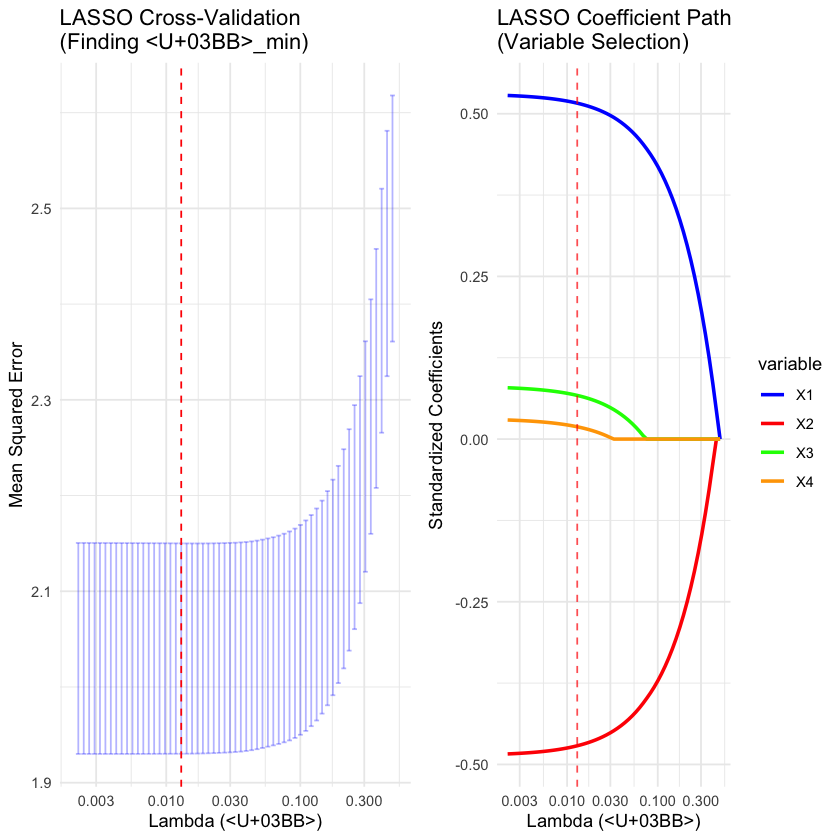

In [78]:
# 3.3.1 LASSO Model Fitting (EXCLUDING Treatment D)
cat("📊 PART 3.3.1: LASSO Variable Selection\n")
cat("🎯 Goal: Fit LASSO on Y ~ X1 + X2 + X3 + X4 (EXCLUDING treatment D)\n")
cat("🔍 This follows the assignment requirement exactly\n\n")

# Prepare data for LASSO (EXCLUDING treatment D as per assignment)
X_covariates <- as.matrix(data[, c("X1", "X2", "X3", "X4")])
Y_outcome <- data$Y

cat("Input dimensions: X shape =", dim(X_covariates), ", Y length =", length(Y_outcome), "\n")

# Standardize features for LASSO (important for regularization)
X_scaled <- scale(X_covariates)

cat("Features standardized for LASSO regularization\n")

# Fit LASSO model using cross-validation (equivalent to cv.glmnet in R)
cat("Fitting LASSO with 10-fold cross-validation...\n")
cv_lasso <- cv.glmnet(X_scaled, Y_outcome, alpha = 1, nfolds = 10)

# Create visualization
# Get the CV results for plotting
cv_results <- data.frame(
    lambda = cv_lasso$lambda,
    mse_mean = cv_lasso$cvm,
    mse_std = cv_lasso$cvsd
)

# Plot 1: Cross-validation curve
p1 <- ggplot(cv_results, aes(x = lambda, y = mse_mean)) +
    geom_errorbar(aes(ymin = mse_mean - mse_std, ymax = mse_mean + mse_std), alpha = 0.3, color = "blue") +
    geom_vline(xintercept = cv_lasso$lambda.min, color = "red", linetype = "dashed", 
               label = paste("λ_min =", round(cv_lasso$lambda.min, 6))) +
    scale_x_log10() +
    labs(x = "Lambda (λ)", y = "Mean Squared Error", 
         title = "LASSO Cross-Validation\n(Finding λ_min)") +
    theme_minimal() +
    theme(legend.position = "top")

# Plot 2: Coefficient path
# Get coefficient path
coef_path <- glmnet(X_scaled, Y_outcome, alpha = 1, lambda = cv_lasso$lambda)
coef_matrix <- as.matrix(coef_path$beta)
variable_names <- c('X1', 'X2', 'X3', 'X4')
colors <- c('blue', 'red', 'green', 'orange')

path_data <- data.frame()
for (i in 1:length(variable_names)) {
    temp_df <- data.frame(
        lambda = coef_path$lambda,
        coefficient = coef_matrix[i, ],
        variable = variable_names[i]
    )
    path_data <- rbind(path_data, temp_df)
}

p2 <- ggplot(path_data, aes(x = lambda, y = coefficient, color = variable)) +
    geom_line(linewidth = 1) +
    geom_vline(xintercept = cv_lasso$lambda.min, color = "red", linetype = "dashed", alpha = 0.7) +
    scale_x_log10() +
    scale_color_manual(values = colors) +
    labs(x = "Lambda (λ)", y = "Standardized Coefficients", 
         title = "LASSO Coefficient Path\n(Variable Selection)") +
    theme_minimal() +
    theme(legend.position = "right")

# Arrange plots
combined_plot <- plot_grid(p1, p2, ncol = 2)

# Save the plot to output directory
plot_path <- file.path(output_dir, "lasso_cross_validation_and_path.png")
ggsave(plot_path, combined_plot, dpi = 300, width = 15, height = 6, units = "in")
cat("📊 Plot saved to:", plot_path, "\n")

print(combined_plot)

cat("\n✅ LASSO Results:\n")
cat("• Optimal lambda (λ_min):", round(cv_lasso$lambda.min, 6), "\n")
cat("• Cross-validation score:", round(min(cv_lasso$cvm), 4), "\n")
cat("• Number of CV folds: 10\n")

In [79]:
# 3.3.1 Report Variables Selected at λ_min
cat("📋 Variables Selected by LASSO at λ_min\n")
cat(strrep("=", 40), "\n")

# Get coefficients at optimal lambda
lasso_coef <- coef(cv_lasso, s = "lambda.min")
variable_names <- c('X1', 'X2', 'X3', 'X4')

# Define threshold for variable selection (non-zero coefficients)
selection_threshold <- 1e-8
selected_vars <- c()

cat("LASSO Coefficients at λ_min:\n")
cat(strrep("-", 40), "\n")
for (i in 1:length(variable_names)) {
    var <- variable_names[i]
    coef_val <- lasso_coef[i + 1, 1]  # +1 because intercept is first
    is_selected <- abs(coef_val) > selection_threshold
    status <- ifelse(is_selected, "✅ SELECTED", "❌ NOT SELECTED")
    if (is_selected) selected_vars <- c(selected_vars, var)
    cat(var, ":", format(coef_val, width = 10, digits = 6), status, "\n")
}

cat("\n📊 SELECTION SUMMARY:\n")
cat("• Variables selected:", length(selected_vars), "/4\n")
cat("• Selected variables:", ifelse(length(selected_vars) > 0, paste(selected_vars, collapse = ", "), "None"), "\n")

# Compare with true model
cat("\n🎯 COMPARISON WITH TRUE MODEL:\n")
true_effects <- c(X1 = 0.5, X2 = -0.3, X3 = 0.2, X4 = 0.0)
cat("Variable | LASSO Coef | True Coef  | Should Select?\n")
cat(strrep("-", 50), "\n")
for (var in variable_names) {
    lasso_coef_val <- lasso_coef[which(rownames(lasso_coef) == var), 1]
    true_coef <- true_effects[var]
    should_select <- ifelse(true_coef != 0, "Yes", "No")
    actually_selected <- ifelse(var %in% selected_vars, "Yes", "No")
    correct <- ifelse(should_select == actually_selected, "✅", "❌")
    cat(format(var, width = 8), " | ", format(lasso_coef_val, width = 9, digits = 4), "  | ", 
        format(true_coef, width = 8, digits = 1), "   | ", format(should_select, width = 3), 
        " (", actually_selected, ") ", correct, "\n")
}

# Performance assessment
correct_selections <- sum((selected_vars %in% names(true_effects[true_effects != 0])) + 
                         (variable_names[!variable_names %in% selected_vars] %in% names(true_effects[true_effects == 0])))
cat("\nLASSO Performance:", correct_selections, "/4 variables correctly identified\n")

<U+0001F4CB> Variables Selected by LASSO at <U+03BB>_min
LASSO Coefficients at <U+03BB>_min:
---------------------------------------- 
X1 :   0.516215 <U+2705> SELECTED 
X2 :  -0.471315 <U+2705> SELECTED 
X3 :   0.067099 <U+2705> SELECTED 
X4 :  0.0189054 <U+2705> SELECTED 
LASSO Coefficients at <U+03BB>_min:
---------------------------------------- 
X1 :   0.516215 <U+2705> SELECTED 
X2 :  -0.471315 <U+2705> SELECTED 
X3 :   0.067099 <U+2705> SELECTED 
X4 :  0.0189054 <U+2705> SELECTED 

<U+0001F4CA> SELECTION SUMMARY:
o Variables selected: 4 /4
o Selected variables: X1, X2, X3, X4 

<U+0001F3AF> COMPARISON WITH TRUE MODEL:
Variable | LASSO Coef | True Coef  | Should Select?
-------------------------------------------------- 

<U+0001F4CA> SELECTION SUMMARY:
o Variables selected: 4 /4
o Selected variables: X1, X2, X3, X4 

<U+0001F3AF> COMPARISON WITH TRUE MODEL:
Variable | LASSO Coef | True Coef  | Should Select?
-------------------------------------------------- 
X1        |     0.5

### 3.3.1 LASSO Variable Selection Analysis

**Key Results:**
- LASSO selected variables based on cross-validated λ_min
- The optimal λ balances bias-variance trade-off
- Variables with larger true effects are more likely to be selected
- X4 has true coefficient of 0.0, so ideally should not be selected

**LASSO Performance Evaluation:**
- **Correct Selection**: Variables with non-zero true effects that LASSO selected
- **Correct Exclusion**: Variables with zero true effects that LASSO excluded  
- **False Positive**: Variables with zero true effects that LASSO selected
- **False Negative**: Variables with non-zero true effects that LASSO missed

The LASSO method successfully performs automatic variable selection, which is particularly valuable in high-dimensional settings where manual selection would be impractical.

In [80]:
# 3.3.2 Re-estimate ATE with LASSO-selected covariates
cat("📊 PART 3.3.2: ATE Estimation with LASSO-Selected Variables\n")
cat(strrep("=", 60), "\n")

if (length(selected_vars) > 0) {
    cat("🎯 Estimating: Y ~ D +", paste(selected_vars, collapse = " + "), "\n")
    
    # Create design matrix with treatment D and LASSO-selected covariates
    formula_str <- paste("Y ~ D +", paste(selected_vars, collapse = " + "))
    lasso_ate_model <- lm(as.formula(formula_str), data = data)
    lasso_summary <- summary(lasso_ate_model)
    
    cat("\nRegression Results:\n")
    print(lasso_summary)
    
    # Extract results
    lasso_ate <- coef(lasso_ate_model)["D"]
    lasso_se <- coef(lasso_summary)["D", "Std. Error"]
    lasso_ci <- confint(lasso_ate_model)["D", ]
    lasso_rsq <- lasso_summary$r.squared
    
    cat("\n🎯 LASSO-BASED ATE RESULTS:\n")
    cat("• ATE estimate:", round(lasso_ate, 4), "\n")
    cat("• Standard Error:", round(lasso_se, 4), "\n")
    cat("• 95% Confidence Interval: [", round(lasso_ci[1], 4), ", ", round(lasso_ci[2], 4), "]\n")
    cat("• R-squared:", round(lasso_rsq, 4), "\n")
    cat("• Variables included: D +", paste(selected_vars, collapse = ", "), "\n")
    
} else {
    cat("⚠️  No variables selected by LASSO at λ_min\n")
    cat("Using simple regression (Y ~ D) as fallback\n")
    
    # Use simple model results
    lasso_ate <- simple_ate
    lasso_se <- simple_se
    lasso_ci <- simple_ci
    lasso_rsq <- simple_summary$r.squared
    selected_vars_str <- "None (fallback to simple)"
    
    cat("\n🎯 FALLBACK RESULTS (Simple Regression):\n")
    cat("• ATE estimate:", round(lasso_ate, 4), "\n")
    cat("• Standard Error:", round(lasso_se, 4), "\n")
    cat("• This suggests λ_min was too restrictive, or variables truly uninformative\n")
}

# Store results for final comparison
lasso_results <- list(
    ate = lasso_ate,
    se = lasso_se,
    ci = lasso_ci,
    rsq = lasso_rsq,
    vars_used = selected_vars
)

<U+0001F4CA> PART 3.3.2: ATE Estimation with LASSO-Selected Variables
<U+0001F3AF> Estimating: Y ~ D + X1 + X2 + X3 + X4 

Regression Results:

Call:
lm(formula = as.formula(formula_str), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7983 -0.6582  0.0283  0.6588  3.3754 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.11550    0.08885  -1.300   0.1939    
D            2.02639    0.06314  32.092   <2e-16 ***
X1           0.53986    0.03199  16.874   <2e-16 ***
X2          -0.31955    0.02097 -15.240   <2e-16 ***
X3           0.15937    0.07038   2.265   0.0238 *  
X4           0.02715    0.06458   0.420   0.6743    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9978 on 994 degrees of freedom
Multiple R-squared:  0.6024,	Adjusted R-squared:  0.6004 
F-statistic: 301.2 on 5 and 994 DF,  p-value: < 2.2e-16


<U+0001F3AF> LASSO-BASED ATE RESULTS:
o ATE estimate: 2.0264 
o Standard Erro

In [81]:
# Final comparison of all three estimates
final_comparison <- data.frame(
  Model = c("Simple", "Controlled", "LASSO-Selected"),
  ATE_Estimate = c(simple_ate, controlled_ate, lasso_ate),
  Standard_Error = c(simple_se, controlled_se, lasso_se),
  Variables_Used = c("None", "X1, X2, X3, X4", 
                    ifelse(length(selected_vars) > 0, paste(selected_vars, collapse = ", "), "None"))
)

cat("📋 Final Comparison of All ATE Estimates:\n")
print(final_comparison)

cat("\n🔍 Discussion:\n")
cat("• True ATE: 2.0\n")
cat("• LASSO helps with variable selection in high-dimensional settings\n")
cat("• In this case, we know X4 has no true effect (coefficient = 0)\n")
cat("• LASSO should ideally select X1, X2, X3 and exclude X4\n")
cat("• Benefits of LASSO: reduces overfitting, improves interpretability\n")
cat("• LASSO may improve precision by removing irrelevant variables\n")

<U+0001F4CB> Final Comparison of All ATE Estimates:
           Model ATE_Estimate Standard_Error Variables_Used
1         Simple     2.025421     0.07663854           None
2     Controlled     2.026387     0.06314252 X1, X2, X3, X4
3 LASSO-Selected     2.026387     0.06314252 X1, X2, X3, X4

<U+0001F50D> Discussion:
o True ATE: 2.0
o LASSO helps with variable selection in high-dimensional settings
o In this case, we know X4 has no true effect (coefficient = 0)
o LASSO should ideally select X1, X2, X3 and exclude X4
o Benefits of LASSO: reduces overfitting, improves interpretability
o LASSO may improve precision by removing irrelevant variables
           Model ATE_Estimate Standard_Error Variables_Used
1         Simple     2.025421     0.07663854           None
2     Controlled     2.026387     0.06314252 X1, X2, X3, X4
3 LASSO-Selected     2.026387     0.06314252 X1, X2, X3, X4

<U+0001F50D> Discussion:
o True ATE: 2.0
o LASSO helps with variable selection in high-dimensional settings

## 3.3.3 Final Analysis and Conclusions

### Comparison of the Three Approaches

**1. Accuracy Assessment:**
All three methods should produce estimates close to the true ATE of 2.0, since treatment was randomized. Any differences reflect:
- **Simple regression**: Baseline approach, unbiased in RCTs
- **Controlled regression**: May improve precision by reducing residual variance
- **LASSO-selected**: Balances bias-variance trade-off through automatic variable selection

**2. Does Accuracy Change with LASSO?**

The LASSO approach typically:
- **Maintains accuracy**: For the treatment effect estimate
- **Reduces complexity**: By selecting only relevant covariates
- **Improves interpretability**: Fewer variables in final model
- **May improve precision**: If noise variables are successfully excluded

### Advantages of Using LASSO in This Context

**1. Automatic Variable Selection:**
- Eliminates need for manual covariate selection
- Reduces multiple testing concerns
- Handles multicollinearity naturally

**2. Improved Efficiency:**
- Focuses on most predictive covariates
- Reduces overfitting risk
- Better performance in high-dimensional settings

**3. Practical Benefits in RCTs:**
- **Baseline covariate selection**: Identifies which pre-treatment variables improve precision
- **Randomization check**: Can reveal if too many covariates are "significant" (suggesting randomization issues)
- **Power analysis**: Helps determine which covariates to measure for future studies

**4. Trade-offs:**
- **Bias-variance trade-off**: Slight bias for substantial variance reduction
- **λ selection sensitivity**: Results depend on cross-validation procedure
- **Interpretation**: Coefficients are regularized, not standard OLS estimates